# Setup

In [15]:
%matplotlib inline

In [16]:
# Library imports
from fastai.vision.all import *
from nbdev.showdoc import *

set_seed(42) # for reproducible random numbers

In [17]:
# Change this to another device (0-7) if you run out of memory
# Goto Kernel->Restart&Clear Output after changing the device
torch.cuda.set_device(4)

In [18]:
# Batch size: https://docs.paperspace.com/machine-learning/wiki/epoch
# Typically 32 works fine, feel free to experiment with it
# If you run out of memory, try to lower the number
bs = 32

# Get Data

In [19]:
path = untar_data(URLs.MNIST); path


Path('/home/ele_group_2/.fastai/data/mnist_png')

In [20]:
path.ls()[1].ls() #[0].ls()

(#10) [Path('/home/ele_group_2/.fastai/data/mnist_png/training/2'),Path('/home/ele_group_2/.fastai/data/mnist_png/training/7'),Path('/home/ele_group_2/.fastai/data/mnist_png/training/9'),Path('/home/ele_group_2/.fastai/data/mnist_png/training/8'),Path('/home/ele_group_2/.fastai/data/mnist_png/training/5'),Path('/home/ele_group_2/.fastai/data/mnist_png/training/3'),Path('/home/ele_group_2/.fastai/data/mnist_png/training/4'),Path('/home/ele_group_2/.fastai/data/mnist_png/training/6'),Path('/home/ele_group_2/.fastai/data/mnist_png/training/0'),Path('/home/ele_group_2/.fastai/data/mnist_png/training/1')]

### Step 1 - Data Loader

In [21]:
get_image_files(path)

(#70000) [Path('/home/ele_group_2/.fastai/data/mnist_png/testing/2/995.png'),Path('/home/ele_group_2/.fastai/data/mnist_png/testing/2/8450.png'),Path('/home/ele_group_2/.fastai/data/mnist_png/testing/2/5629.png'),Path('/home/ele_group_2/.fastai/data/mnist_png/testing/2/9480.png'),Path('/home/ele_group_2/.fastai/data/mnist_png/testing/2/2058.png'),Path('/home/ele_group_2/.fastai/data/mnist_png/testing/2/7762.png'),Path('/home/ele_group_2/.fastai/data/mnist_png/testing/2/9847.png'),Path('/home/ele_group_2/.fastai/data/mnist_png/testing/2/646.png'),Path('/home/ele_group_2/.fastai/data/mnist_png/testing/2/633.png'),Path('/home/ele_group_2/.fastai/data/mnist_png/testing/2/4204.png')...]

In [22]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

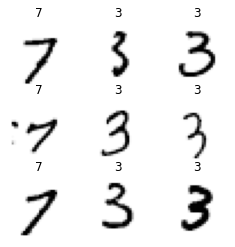

In [23]:
dls = mnist.dataloaders(untar_data(URLs.MNIST_TINY))
dls.show_batch(max_n=9, figsize=(4,4))

In [24]:
mnist.summary(untar_data(URLs.MNIST_TINY))

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/ele_group_2/.fastai/data/mnist_tiny/train/7/7994.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/ele_group_2/.fastai/data/mnist_tiny/train/7/7994.png
    applying parent_label gives
      7
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(1))


Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item:

### Step 2 - Building a Model

learner = cnn_learner(data_loader, resnet34, metrics=error_rate) 

In [25]:
learner = cnn_learner(dls, resnet34, metrics=error_rate)

/home/ele_group_2/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [26]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Step 3 - Learning

In [27]:
learner.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.865828,0.841290,0.301860,00:01
1,0.589940,0.376160,0.130186,00:01
2,0.441252,0.233606,0.080114,00:01


In [29]:
learner.save('stage-1')

Path('models/stage-1.pth')

In [30]:
# You can access the final result through learner.recorder.metrics[0].value
# Sice Accuracy is defined as 1-error_rate let's print that
print("Accuracy: ", 1-float(learner.recorder.metrics[0].value))

Accuracy:  0.91988555341959


In [31]:
# Interpretations are usefull to get some information about our models
interpretation = ClassificationInterpretation.from_learner(learner)
#losses,indexes = interpretation.top_losses()
#len(data_loader.valid_ds)==len(losses)==len(indexes)

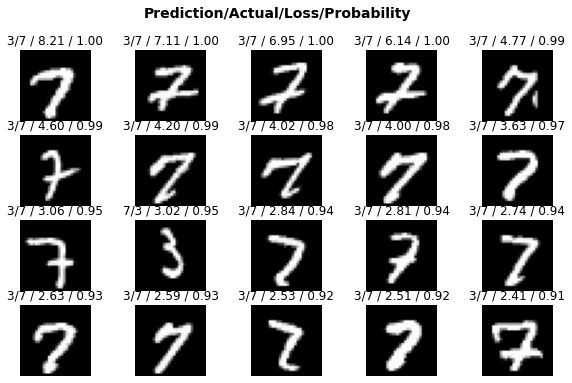

In [32]:
interpretation.plot_top_losses(20, figsize=(10 ,6))

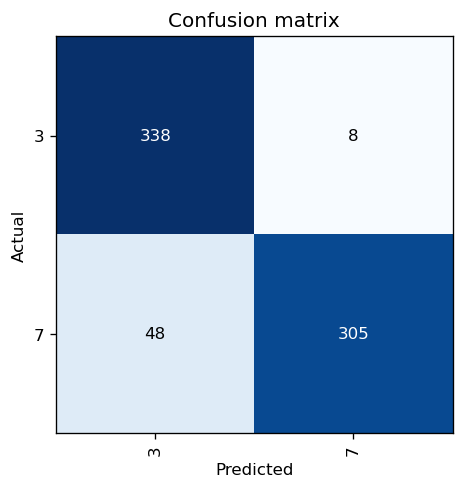

In [33]:
interpretation.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [34]:
interpretation.most_confused(min_val=2)

[('7', '3', 48), ('3', '7', 8)]

### Step 4 - Some Optimizations

In [35]:
learner = cnn_learner(dls, resnet50, metrics=error_rate)

/home/ele_group_2/miniconda3/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0012022644514217973)

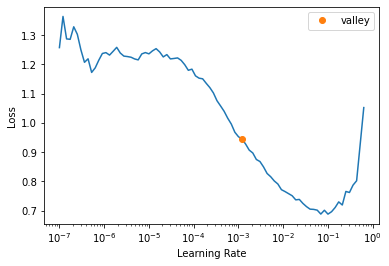

In [36]:
learner.lr_find()

In [39]:
# As a rule of thumb, we pick the lowest point and go back one exponent (for example from -1 to -2)
# The finder also prints the minimum and the steepes area. You can also pick the value of lr_steep for lr_max
# NOTE: change lr_max to the actual value from your graph
learner.fit_one_cycle(3, lr_max=0.0016)

epoch,train_loss,valid_loss,error_rate,time
0,0.109619,0.178983,0.044349,00:02
1,0.122098,0.170399,0.045780,00:02
2,0.098473,0.167978,0.054363,00:01


In [40]:
print("Accuracy: ", 1-float(learner.recorder.metrics[0].value))

Accuracy:  0.945636622607708


In [41]:
learner.save('stage-1-50')

Path('models/stage-1-50.pth')

In [44]:
learner.unfreeze()
learner.fit_one_cycle(3, lr_max=slice(1e-5,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.123492,0.282118,0.055794,00:02
1,0.122527,0.238614,0.047210,00:02
2,0.090968,0.175208,0.047210,00:02


In [45]:
print("Accuracy: ", 1-float(learner.recorder.metrics[0].value))

Accuracy:  0.9527896977961063


In [46]:
# If the results are better, we keep the new model, otherwise we can reload the previous one
learner.save('stage-2-50')
# learner.load('stage-1-50')

Path('models/stage-2-50.pth')

In [47]:
interpretation = ClassificationInterpretation.from_learner(learner)

In [48]:
interpretation.most_confused(min_val=2)

[('3', '7', 18), ('7', '3', 15)]